In [50]:
import tensorflow as tf
import numpy as np
from common import *
import ast

from asyncio.events import  AbstractEventLoop
import logging
import os, time
from numba import jit
import tflearn
from io import StringIO


logging.basicConfig(level=logging.DEBUG)
os.environ['PYTHONASYNCIODEBUG'] = '1'


def parse_json(texts):
    return [[json.loads(text.decode('utf-8')) for text in texts]]


def read_my_file_format(filename_queue):
    reader = tf.WholeFileReader()
    key, record_string = reader.read(filename_queue)
    example = tf.py_func(parse_json, [record_string], [tf.int32])
#     processed_example = some_processing(example)
    return example, key

def input_pipeline(filenames, batch_size, num_epochs=None):
    filename_queue = tf.train.string_input_producer(
      filenames, num_epochs=num_epochs, shuffle=True)
    example, label = read_my_file_format(filename_queue)
    # min_after_dequeue defines how big a buffer we will randomly sample
    #   from -- bigger means better shuffling but slower start up and more
    #   memory used.
    # capacity must be larger than min_after_dequeue and the amount larger
    #   determines the maximum we will prefetch.  Recommendation:
    #   min_after_dequeue + (num_threads + a small safety margin) * batch_size
    min_after_dequeue = 10000
    capacity = min_after_dequeue + 3 * batch_size
    example_batch, label_batch = tf.train.shuffle_batch(
        [example, label], 
        batch_size=batch_size, 
        capacity=capacity,
        min_after_dequeue=min_after_dequeue,
        allow_smaller_final_batch=True,
        num_threads=4
    )
    return example_batch, label_batch

In [27]:
filenames = list(islice(iglob('../data/corpus/*.json'), 100))
# filenames = glob('../data/corpus/*.json')

In [49]:
start_time = time.time()

with tf.Graph().as_default():        
        
    sess = tf.Session()
    with sess.as_default():

        example_batch, label_batch = input_pipeline(filenames, batch_size=64, num_epochs=1)        
        
        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])
                
        # Start input enqueue threads.
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        it = 0
        try:
            while not coord.should_stop():
                batches, keys = sess.run([example_batch, label_batch])        
                print(it)
                it += 1
        except tf.errors.OutOfRangeError:
            print('Done training -- epoch limit reached')
        finally:
            # When done, ask the threads to stop.
            coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)        

print("--- %s seconds ---" % (time.time() - start_time))

ValueError: Cannot infer Tensor's rank: Tensor("shuffle_batch/packed:0", dtype=int32)

In [27]:
len(filenames)//64

19795

In [28]:
len(filenames)

1266940

In [18]:
tf.global_variables()

[]

In [66]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    t1 = [[[[1,2],[3,4],[5,6]], [[7,8],[9,10],[11,12]]]]
    t2 = [[[[21,22],[23,24],[25,26]], [[27,28],[29,30],[31,32]]]]
    
    var = tf.concat([t1, t2], 3)
    
    print(var.eval())

[[[[ 1  2 21 22]
   [ 3  4 23 24]
   [ 5  6 25 26]]

  [[ 7  8 27 28]
   [ 9 10 29 30]
   [11 12 31 32]]]]


In [65]:
t = [[[[1,2],[3,4],[5,6]], [[7,8],[9,10],[11,12]]]]
np.array(t).shape

(1, 2, 3, 2)

In [13]:
ziped_files = sorted(glob(DATA_FOLDER + '/documents/*.gz'), key=natural_keys)


In [35]:
lens = []
for fn in tqdm(ziped_files):
    with GzipFile(fn, 'r') as gzf:
        text = gzf.read()
    docs = json.loads(text)
    for _id,doc in docs.items():
        for sent in doc:
            lens.append(len(sent))

  0%|          | 0/1001 [00:00<?, ?it/s]

['наблюдатель', 'видеть', 'сквозь', 'светоделитель', 'цель', 'неискаженный', 'вид', 'одновременно', 'правый', 'глаз', 'видеть', 'изображение', 'марка', 'построить', 'отражатель', 'бесконечность', 'левый', 'глаз', 'видеть', 'изображение', 'марка', 'построить', 'бесконечность', 'отражатель', 'одинаковость', 'марка', 'параметр', 'отражатель', 'обеспечивать', 'одинаковость', 'восприятие', 'изображение', 'марка', 'правый', 'левый', 'глаз', 'благодаря', 'охотник', 'воспринимать', 'изображение']
['оптический', 'прицел', 'содержать', 'закреплять', 'прицельный', 'планка', 'коллимационный', 'оптический', 'система', 'состоять', 'светоделитель', 'фокусировать', 'отражатель', 'фокальный', 'плоскость', 'который', 'устанавливать', 'марк', 'отличаться', 'цель', 'получение', 'возможность', 'наблюдение', 'цель', 'марка', 'глаз', 'одновременно', 'содержать', 'второй', 'коллимационный', 'оптический', 'система', 'смещать', 'горизонтальный', 'направление', 'относительно', 'первый', 'величина', 'средний', 'м

['достижение', 'выходной', 'число', 'равный', 'единица', 'импульс', 'выход', 'дешифратора', 'переклить', 'чаять', 'триггер', 'режим', 'сложение', 'временно', 'запрещать', 'прохождение', 'импульс', 'ивх', 'схема', 'зиля', 'счетный', 'вход', 'счетчик', 'приход', 'последующий', 'импульс', 'дата', 'чик', 'детонация', 'устанавливать', 'счетчик', 'нулевой', 'состояние', 'цикл', 'работа', 'повторяться', 'аналогично', 'описывать']
['формула', 'изобретение', 'устройство', 'обнаружение', 'детонация', 'коррекция', 'момент', 'искрообразование', 'двигатель', 'внутренний', 'сгорание', 'содержать', 'четыре', 'логический', 'схема', 'первый', 'ре', 'версивный', 'счетчик', 'выход', 'который', 'подключать', 'вход', 'первый', 'дешифратор', 'второй', 'реверсивный', 'сметчик', 'выход', 'который', 'подключать', 'йхпддм', 'второй', 'третий', 'дешифратор', 'мять', 'подключение', 'датчик', 'детонация', 'клемма', 'подключение', 'датчик', 'верхний', 'мертвый', 'точка', 'клемма', 'подключение', 'замок', 'зажигание

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


['угол', 'менее', 'deg', 'ось', 'отверстие', 'бсггшсго', 'упоминать', 'плоскость', 'угпом', 'менее', 'deg', 'суммарный', 'диаметр', 'выходной', 'отверстие', 'воздуховодопы', 'большой', 'диаметр', 'отверстие', 'выходной', 'сопло', 'диаметр', 'больший', 'выходной', 'отверстие', 'большой', 'диаметр', 'отверстие', 'выходной', 'сопло', 'диаметр', 'меньший', 'выходной', 'отверстие', 'маленький', 'диаметр', 'отверстие', 'выходной', 'сопло']
['известный', 'электрометаллизатор', 'который', 'направляющий', 'иметь', 'общий', 'канал', 'одновременный', 'подача', 'электрод', 'воздух', 'газ', 'цель', 'возможный', 'регулирование', 'расположение', 'наконечник', 'последний', 'выполнять', 'поворотный', 'помощь', 'шарнирный', 'соединение', 'направлять', 'недостаток', 'данный', 'конструкция', 'электрометаллизатор', 'пистолет', 'следовать', 'относить', 'отсутствие', 'стабильный', 'горение', 'вольтовый', 'дуга', 'вследствие', 'вибрация', 'проволока', 'электрод', 'точка', 'пересечение', 'воздушный', 'струя', 

KeyboardInterrupt: 

In [16]:
sent

['отличаться',
 'нижний',
 'часть',
 'корпус',
 'выполнять',
 'вентиляционный',
 'отверстие']

In [18]:
lenss = pd.Series(lens)

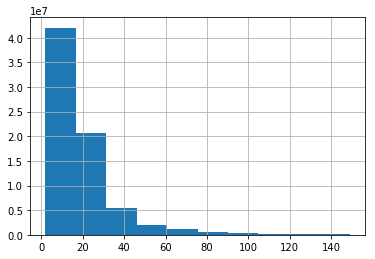

count    7.295999e+07
mean     2.052290e+01
std      5.383325e+01
min      2.000000e+00
25%      9.000000e+00
50%      1.400000e+01
75%      2.300000e+01
max      5.175100e+04
dtype: float64

In [32]:
from matplotlib import pyplot as plt

lenss[lenss<150].hist()
plt.show()
lenss.describe()

In [21]:
np.qulenss

23.0

In [37]:
from scipy.stats.mstats import mquantiles

mquantiles(lenss, prob=[0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99])

array([   3.,    5.,    6.,    8.,    9.,   14.,   23.,   26.,   31.,
         38.,   54.,  113.])

In [27]:
from tensorflow.contrib import learn

In [31]:
vocab_processor = learn.preprocessing.VocabularyProcessor(10)
list(vocab_processor.fit_transform(['привет, как дела? сегодня пойдешь гулять?', 'да, пойду, привет!']))


[array([1, 2, 3, 4, 5, 6, 0, 0, 0, 0]), array([7, 8, 1, 0, 0, 0, 0, 0, 0, 0])]

# AsyncIO

In [1]:
import tensorflow as tf
import threading
import time

In [23]:
with tf.Graph().as_default():        
    sess = tf.Session()
    with sess.as_default():
    
        x = tf.placeholder(tf.int32, shape=(None, None))
#         y = tf.matmul(x, tf.transpose(x))
    
        rand_array = [[1,2],[3,4],[5,6,7]]
        print(sess.run(x, feed_dict={x: rand_array}))  # Will succeed.

ValueError: setting an array element with a sequence.

In [49]:
import numpy
doc = numpy.asarray([ [1,2,3], [4,5,6], [7,8,999999] ], dtype=np.int)
numpy.savetxt("../data/foo.csv", doc, delimiter=",", fmt='%d')

In [50]:
! cat ../data/foo.csv


1,2,3
4,5,6
7,8,999999


In [52]:
def parse_csv(text):
    c = StringIO(text.decode('utf-8'))
    return np.loadtxt(c, dtype=np.int32, delimiter=',')
    

with tf.Graph().as_default():        
    sess = tf.Session()
    with sess.as_default():
    
        record_defaults = [[-1], [-1], [-1]]
        
        filename_queue = tf.train.string_input_producer(['../data/foo.csv']) 
        reader = tf.WholeFileReader()
        key, record_string = reader.read(filename_queue)
        res = tf.py_func(parse_csv, [record_string], tf.int32)
#         res = tf.decode_csv(record_string, record_defaults=record_defaults)
        
        init = tf.global_variables_initializer()
        sess.run(init)

        threads = tf.train.start_queue_runners()
        
        cvv_res = sess.run(res)
        print(cvv_res)

        

[[     1      2      3]
 [     4      5      6]
 [     7      8 999999]]


In [26]:
arr = [[1,],[3,4],[5,6,7]]

tflearn.data_utils.pad_sequences(arr, 2)

array([[1, 0],
       [3, 4],
       [5, 6]], dtype=int32)